In [1]:
import time

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv1D, Dense,  MaxPooling2D, MaxPooling1D, Flatten, Concatenate, GlobalAveragePooling2D, GlobalAveragePooling1D

2024-11-14 16:24:51.495537: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-14 16:24:51.555299: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-14 16:24:51.555347: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-14 16:24:51.555378: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-14 16:24:51.564545: I tensorflow/core/platform/cpu_feature_g

In [2]:
PATH = "/tmp/lhcf-cnn"

In [3]:
# Definisci lo schema del TFRecord
feature_description = {
    "posdE_01xy": tf.io.FixedLenFeature([384 * 384 * 2], tf.float32),
    "posdE_23x": tf.io.FixedLenFeature([384 * 2], tf.float32),
    "posdE_23y": tf.io.FixedLenFeature([384 * 2], tf.float32),
    "dE": tf.io.FixedLenFeature([16], tf.float32),
    "label": tf.io.FixedLenFeature([], tf.int64)
}

# Funzione per il parsing dei record
def parse_tfrecord_fn(example_proto):
    example = tf.io.parse_single_example(example_proto, feature_description)
    
    # Ricostruisci le forme originali
    posdE_01xy = tf.reshape(example["posdE_01xy"], (384, 384, 2))
    posdE_23x = tf.reshape(example["posdE_23x"], (384, 2))
    posdE_23y = tf.reshape(example["posdE_23y"], (384, 2))
    dE = tf.reshape(example["dE"], (16,))
    label = example["label"]
    
    return {"posdE_01xy_input": posdE_01xy, "posdE_23x_input": posdE_23x, "posdE_23y_input": posdE_23y, "dE_input": dE}, label

# Carica e pre-processa i dati in batch
def load_dataset(tfrecord_file, batch_size=32, shuffle_buffer=1000):
    dataset = tf.data.TFRecordDataset(tfrecord_file)
    dataset = dataset.map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle_buffer==None:
        dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    else:
        dataset = dataset.shuffle(shuffle_buffer).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Creazione dei dataset di training e validazione
train_dataset = load_dataset(f"{PATH}/train.tfrecord", batch_size=32)
validation_dataset = load_dataset(f"{PATH}/validation.tfrecord", batch_size=32, shuffle_buffer=None)

2024-11-14 16:24:58.871962: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-14 16:24:58.882149: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-14 16:24:58.882375: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
train_dataset.element_spec

({'posdE_01xy_input': TensorSpec(shape=(None, 384, 384, 2), dtype=tf.float32, name=None),
  'posdE_23x_input': TensorSpec(shape=(None, 384, 2), dtype=tf.float32, name=None),
  'posdE_23y_input': TensorSpec(shape=(None, 384, 2), dtype=tf.float32, name=None),
  'dE_input': TensorSpec(shape=(None, 16), dtype=tf.float32, name=None)},
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [5]:
train_dataset_noshuffle = load_dataset(f"{PATH}/train.tfrecord", batch_size=32, shuffle_buffer=None)

In [6]:
# Conta il numero di esempi con label 0 e 1 nel train_dataset
count_label_0 = 0
count_label_1 = 0

# Itera su train_dataset per contare le label
for _, labels in train_dataset_noshuffle:
    # Converte i tensor delle label in numpy per operazioni semplici
    labels_numpy = labels.numpy()
    count_label_0 += np.sum(labels_numpy == 0)
    count_label_1 += np.sum(labels_numpy == 1)

print(f"Numero di esempi con label 0: {count_label_0}")
print(f"Numero di esempi con label 1: {count_label_1}")
ratio = count_label_0/ count_label_1
print("Rapporto: ",ratio)

Numero di esempi con label 0: 6123
Numero di esempi con label 1: 1877
Rapporto:  3.2621204049014385


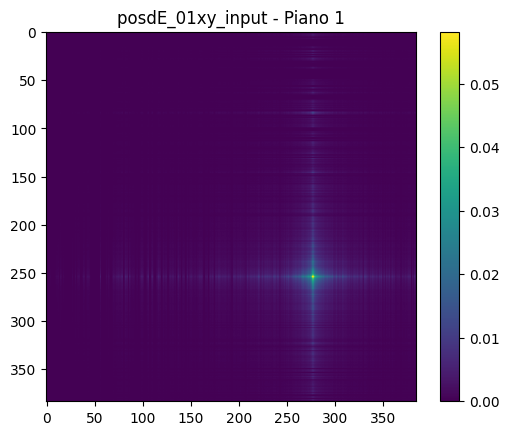

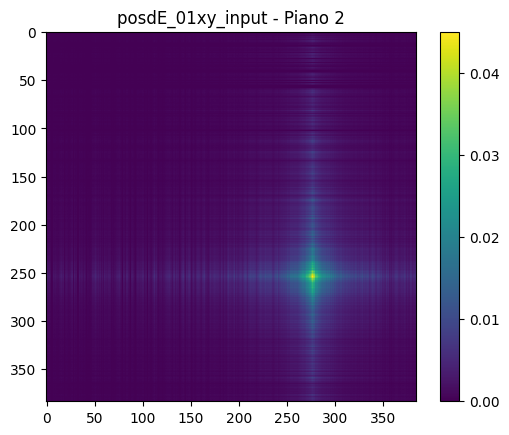

In [7]:
# Estrai un batch dal dataset
for batch in train_dataset_noshuffle.take(1):  # Prende il primo batch
    example = batch[0]  # Prende le feature
    label = batch[1]  # Prende la label
    break

# Estrai un singolo esempio
posdE_01xy_example = example["posdE_01xy_input"].numpy()[2]  # Prende il primo esempio del batch

# Visualizza l'immagine posdE_01xy_input
plt.imshow(posdE_01xy_example[:, :, 0], cmap='viridis')  # Visualizza il primo canale
plt.colorbar()
plt.title("posdE_01xy_input - Piano 1")
plt.show()

# Per visualizzare il secondo canale separatamente
plt.imshow(posdE_01xy_example[:, :, 1], cmap='viridis')  # Visualizza il secondo canale
plt.colorbar()
plt.title("posdE_01xy_input - Piano 2")
plt.show()

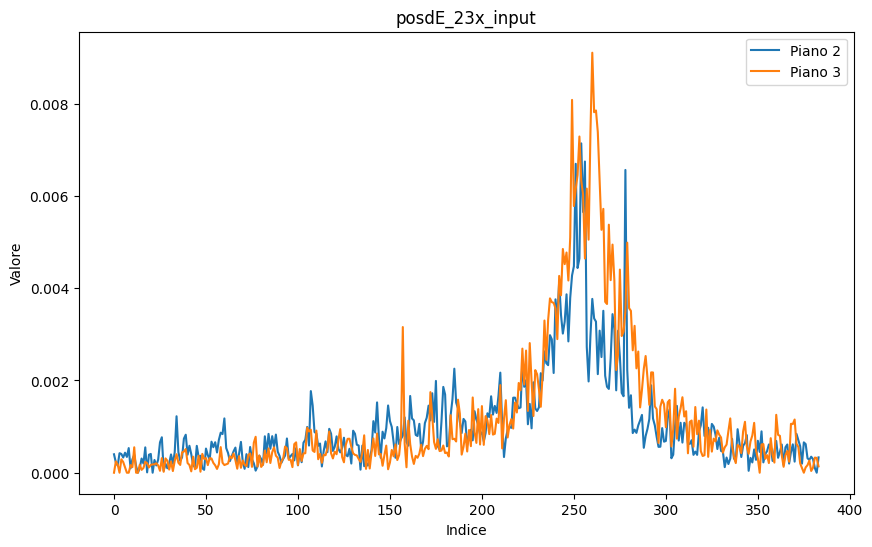

In [8]:
# Estrai un batch dal dataset
for batch in train_dataset_noshuffle.take(1):  # Prende il primo batch
    example = batch[0]  # Prende le feature
    label = batch[1]  # Prende la label
    break

# Estrai un singolo esempio
posdE_23x_example = example["posdE_23x_input"].numpy()[2]  # Prende il primo esempio del batch

# Visualizza i due canali come linee separate
plt.figure(figsize=(10, 6))
plt.plot(posdE_23x_example[:, 0], label="Piano 2")
plt.plot(posdE_23x_example[:, 1], label="Piano 3")
plt.title("posdE_23x_input")
plt.xlabel("Indice")
plt.ylabel("Valore")
plt.legend()
plt.show()

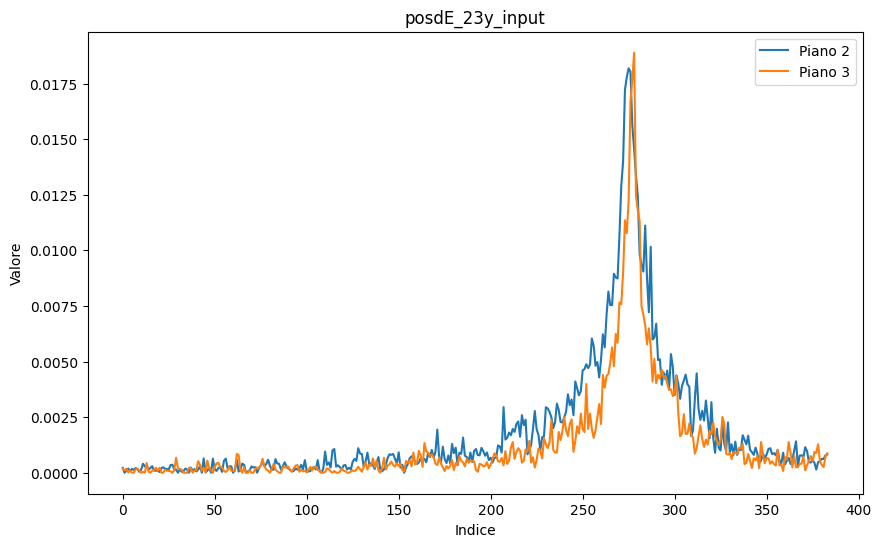

In [9]:
# Estrai un batch dal dataset
for batch in train_dataset_noshuffle.take(1):  # Prende il primo batch
    example = batch[0]  # Prende le feature
    label = batch[1]  # Prende la label
    break

# Estrai un singolo esempio
posdE_23y_example = example["posdE_23y_input"].numpy()[2]  # Prende il primo esempio del batch

# Visualizza i due canali come linee separate
plt.figure(figsize=(10, 6))
plt.plot(posdE_23y_example[:, 0], label="Piano 2")
plt.plot(posdE_23y_example[:, 1], label="Piano 3")
plt.title("posdE_23y_input")
plt.xlabel("Indice")
plt.ylabel("Valore")
plt.legend()
plt.show()

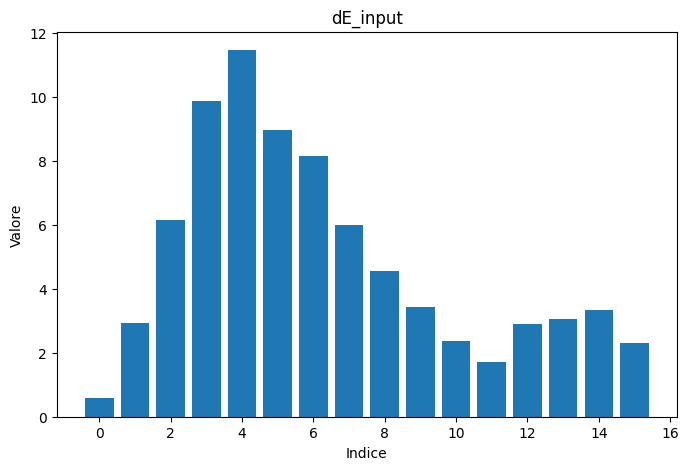

In [10]:
# Estrai un batch dal dataset
for batch in train_dataset_noshuffle.take(1):  # Prende il primo batch
    example = batch[0]  # Prende le feature
    label = batch[1]  # Prende la label
    break

# Estrai un singolo esempio di dE_input
dE_example = example["dE_input"].numpy()[2]  # Prende il primo esempio del batch

# Visualizza dE_input come grafico a barre
plt.figure(figsize=(8, 5))
plt.bar(range(len(dE_example)), dE_example)
plt.title("dE_input")
plt.xlabel("Indice")
plt.ylabel("Valore")
plt.show()

In [11]:
# Definizione della rete neurale

# Input per Conv2D con GlobalAveragePooling
input_posdE_01xy = Input(shape=(384, 384, 2), name="posdE_01xy_input")
x1 = Conv2D(4, (3, 3), activation="relu", padding="same")(input_posdE_01xy)
x1 = MaxPooling2D((2, 2))(x1)
#x1 = GlobalAveragePooling2D()(x1)  # Riducono i parametri
x1 = Flatten()(x1) 

# Input per Conv1D con GlobalAveragePooling
input_posdE_23x = Input(shape=(384, 2), name="posdE_23x_input")
x2 = Conv1D(4, 3, activation="relu", padding="same")(input_posdE_23x)
x2 = MaxPooling1D(2)(x2)
#x2 = GlobalAveragePooling1D()(x2)
x2 = Flatten()(x2)

input_posdE_23y = Input(shape=(384, 2), name="posdE_23y_input")
x3 = Conv1D(4, 3, activation="relu", padding="same")(input_posdE_23y)
x3 = MaxPooling1D(2)(x3)
#x3 = GlobalAveragePooling1D()(x3)
x3 = Flatten()(x3)

# Input per Dense
input_dE = Input(shape=(16,), name="dE_input")
x4 = Dense(4, activation="relu")(input_dE)

# Concatenazione delle rappresentazioni dei quattro blocchi
x = Concatenate()([x1, x2, x3, x4])

# Output per classificazione binaria
output = Dense(1, activation="sigmoid", name="output")(x)

# Definisci il modello
model = Model(inputs=[input_posdE_01xy, input_posdE_23x, input_posdE_23y, input_dE], outputs=output)

In [12]:
# Compila il modello
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Visualizza il sommario del modello
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 posdE_01xy_input (InputLay  [(None, 384, 384, 2)]        0         []                            
 er)                                                                                              
                                                                                                  
 posdE_23x_input (InputLaye  [(None, 384, 2)]             0         []                            
 r)                                                                                               
                                                                                                  
 posdE_23y_input (InputLaye  [(None, 384, 2)]             0         []                            
 r)                                                                                           

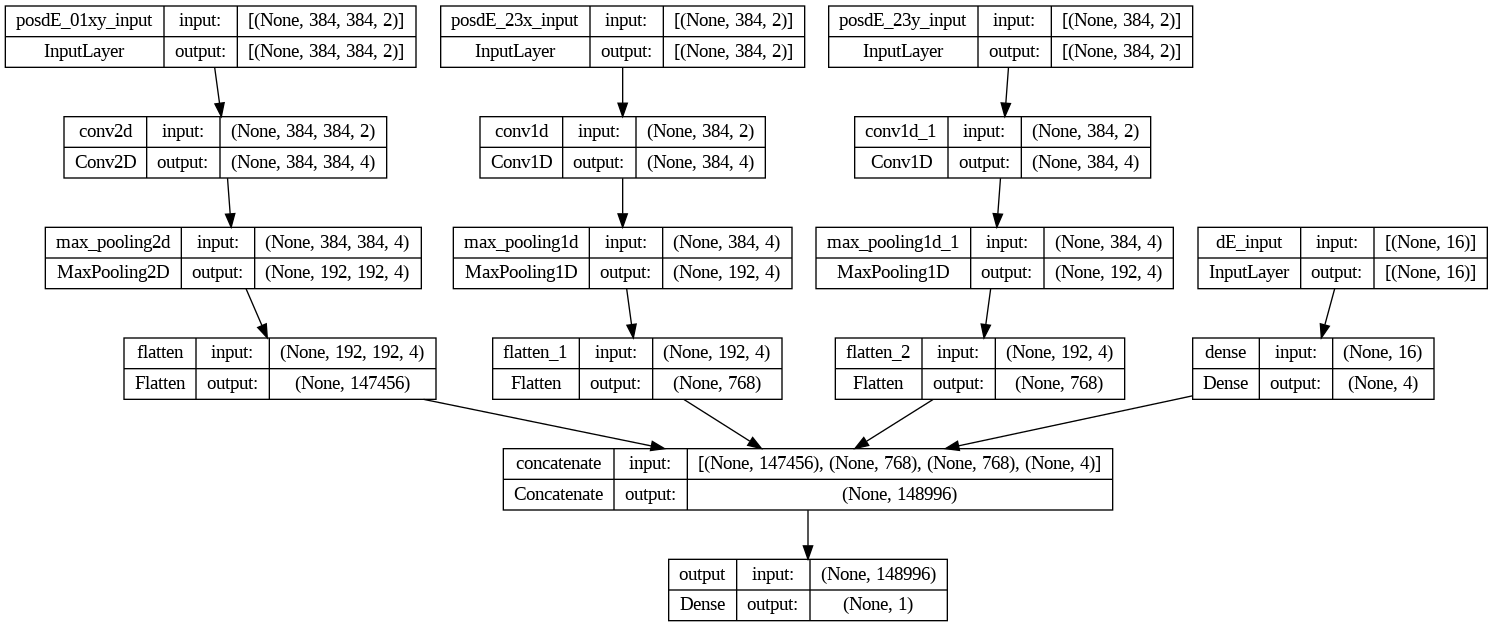

In [13]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [14]:
# Definisci i pesi per le classi
#class_weight = {0: 1, 1: 3}  

# Allena il modello
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=20,
    #class_weight=class_weight
)

Epoch 1/20


2024-11-14 16:25:16.685873: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-11-14 16:25:17.416213: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-11-14 16:25:17.698332: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-11-14 16:25:18.839312: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f467c8e65d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-14 16:25:18.839361: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2024-11-14 16:25:18.856646: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-14 16:25:19.036580: I ./tensorflow/compiler/jit/device_compiler.h:1

250/250 [==============================] - 15s 37ms/step - loss: 0.4413 - accuracy: 0.7931 - val_loss: 0.3300 - val_accuracy: 0.9400
Epoch 2/20


2024-11-14 16:25:29.556511: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9368462877764279095
2024-11-14 16:25:29.556562: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14081314751244235975
2024-11-14 16:25:29.556571: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9118892955950300697
2024-11-14 16:25:29.556580: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14952012592516356049
2024-11-14 16:25:29.556598: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12171745092471610712


250/250 [==============================] - 7s 26ms/step - loss: 0.2481 - accuracy: 0.9086 - val_loss: 0.2171 - val_accuracy: 0.9200
Epoch 3/20
250/250 [==============================] - 7s 27ms/step - loss: 0.1847 - accuracy: 0.9356 - val_loss: 0.1913 - val_accuracy: 0.9420
Epoch 4/20
250/250 [==============================] - 7s 25ms/step - loss: 0.1531 - accuracy: 0.9469 - val_loss: 0.1481 - val_accuracy: 0.9480
Epoch 5/20
250/250 [==============================] - 7s 25ms/step - loss: 0.1306 - accuracy: 0.9570 - val_loss: 0.1320 - val_accuracy: 0.9550
Epoch 6/20
250/250 [==============================] - 7s 25ms/step - loss: 0.1177 - accuracy: 0.9616 - val_loss: 0.1632 - val_accuracy: 0.9380
Epoch 7/20
250/250 [==============================] - 7s 26ms/step - loss: 0.1114 - accuracy: 0.9657 - val_loss: 0.1108 - val_accuracy: 0.9745
Epoch 8/20
250/250 [==============================] - 7s 25ms/step - loss: 0.0970 - accuracy: 0.9711 - val_loss: 0.1215 - val_accuracy: 0.9625
Epoch 9/20

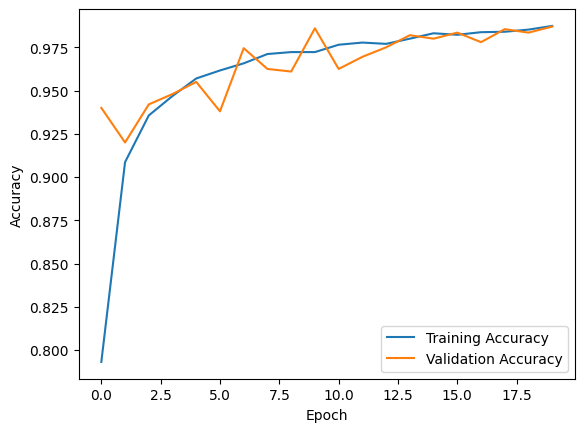

In [15]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

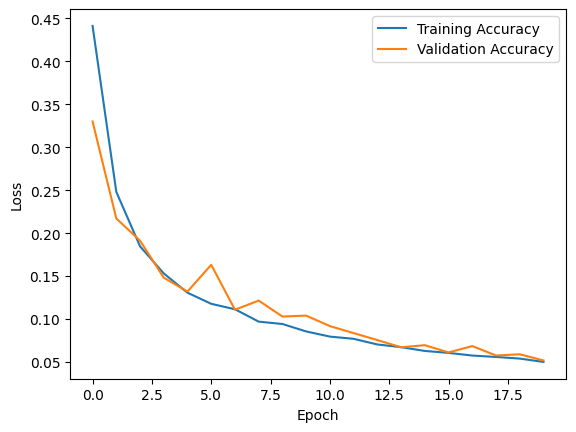

In [16]:
plt.plot(history.history['loss'], label='Training Accuracy')
plt.plot(history.history['val_loss'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
# Calcola le etichette e le predizioni per il dataset di training senza shuffle
y_train_true = np.concatenate([y for _, y in train_dataset_noshuffle.as_numpy_iterator()], axis=0)
train_predictions = model.predict(train_dataset_noshuffle)

# Dividi le predizioni del training in base alle etichette
train_predictions_0 = train_predictions[y_train_true == 0]
train_predictions_1 = train_predictions[y_train_true == 1]

# Calcola le etichette e le predizioni per il dataset di validazione senza shuffle
y_val_true = np.concatenate([y for _, y in validation_dataset.as_numpy_iterator()], axis=0)
val_predictions = model.predict(validation_dataset)

# Dividi le predizioni della validazione in base alle etichette
val_predictions_0 = val_predictions[y_val_true == 0]
val_predictions_1 = val_predictions[y_val_true == 1]


250/250 [==============================] - 4s 14ms/step


2024-11-14 16:27:57.527247: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16894070019620551067
2024-11-14 16:27:57.527318: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9368462877764279095
2024-11-14 16:27:57.527330: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9118892955950300697
2024-11-14 16:27:57.527348: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14952012592516356049


63/63 [==============================] - 1s 15ms/step


2024-11-14 16:27:59.681118: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16894070019620551067
2024-11-14 16:27:59.681170: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9368462877764279095
2024-11-14 16:27:59.681180: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9118892955950300697
2024-11-14 16:27:59.681199: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14952012592516356049


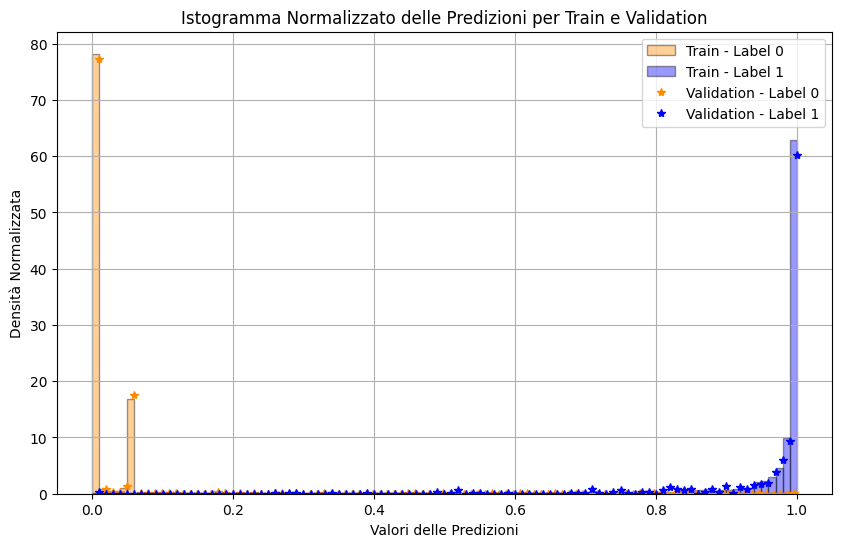

In [18]:
# Plottaggio degli istogrammi normalizzati
plt.figure(figsize=(10, 6))

# Istogramma per train_predictions_label_0 e train_predictions_label_1
# Normalizza ciascun istogramma affinché l'area totale sia 1
train_hist_0, bins_0, _ = plt.hist(train_predictions_0, bins=100, alpha=0.4, color='darkorange', label='Train - Label 0', edgecolor='black', density=True)
train_hist_1, bins_1, _ = plt.hist(train_predictions_1, bins=100, alpha=0.4, color='blue', label='Train - Label 1', edgecolor='black', density=True)

# Istogrammi per la validazione (senza visualizzazione)
val_hist_0, bin_val_0 = np.histogram(val_predictions_0, bins=100, density=True)
val_hist_1, bin_val_1 = np.histogram(val_predictions_1, bins=100, density=True)

plt.plot(bin_val_0[1:], val_hist_0, '*', color='darkorange', label='Validation - Label 0')
plt.plot(bin_val_1[1:], val_hist_1, '*', color='blue', label='Validation - Label 1')

# Aggiungi etichette e legenda
plt.xlabel("Valori delle Predizioni")
plt.ylabel("Densità Normalizzata")
plt.title("Istogramma Normalizzato delle Predizioni per Train e Validation")
plt.legend()
plt.grid(True)

plt.show()

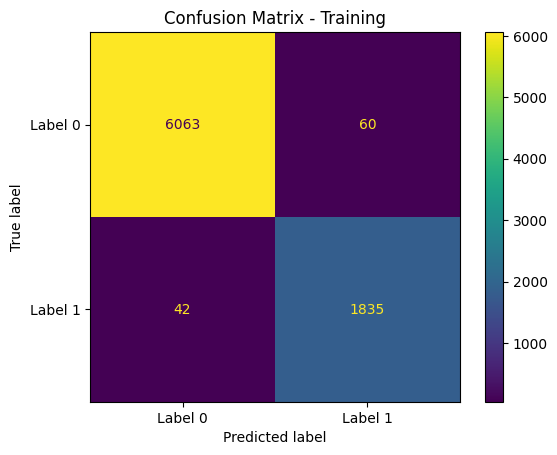

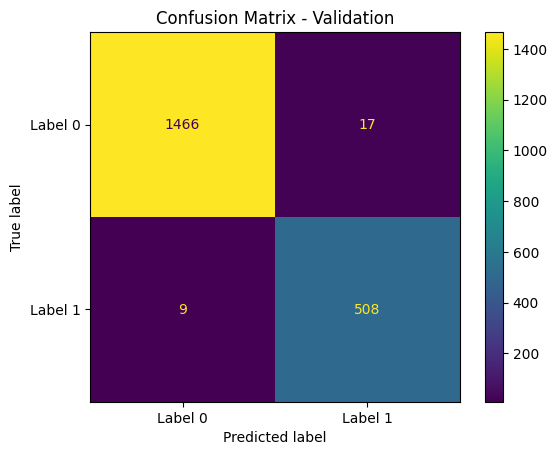

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predizione per l'intero dataset 
#y_train_true = np.concatenate([y for _, y in train_dataset_noshuffle.as_numpy_iterator()], axis=0)
#train_predictions = model.predict(train_dataset_noshuffle)
y_train_pred = (train_predictions >= 0.5).astype(int)

#y_val_true = np.concatenate([y for _, y in validation_dataset.as_numpy_iterator()], axis=0)
#val_predictions = model.predict(validation_dataset)
y_val_pred = (val_predictions >= 0.5).astype(int)

# Calcola la matrice di confusione per il training
train_cm = confusion_matrix(y_train_true, y_train_pred)
ConfusionMatrixDisplay(train_cm, display_labels=['Label 0', 'Label 1']).plot()
plt.title('Confusion Matrix - Training')
plt.show()

# Calcola la matrice di confusione per la validazione
val_cm = confusion_matrix(y_val_true, y_val_pred)
ConfusionMatrixDisplay(val_cm, display_labels=['Label 0', 'Label 1']).plot()
plt.title('Confusion Matrix - Validation')
plt.show()